In [219]:
import numpy as np
import pandas as pd
import networkx as nx
import bct
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# Setup

In [220]:
# change defaults to be less ugly
mpl.rc('xtick', labelsize=14, color="#222222") 
mpl.rc('ytick', labelsize=14, color="#222222") 
mpl.rc('font', **{'family':'sans-serif','sans-serif':['Arial']})
mpl.rc('font', size=16)
mpl.rc('xtick.major', size=6, width=1)
mpl.rc('xtick.minor', size=3, width=1)
mpl.rc('ytick.major', size=6, width=1)
mpl.rc('ytick.minor', size=3, width=1)
mpl.rc('axes', linewidth=1, edgecolor="#222222", labelcolor="#222222")
mpl.rc('text', usetex=False, color="#222222")

In [221]:
files = ['test','training','validation']
# Keep track of nodes that are in the matrices
tracked_nodes = [1] * 200

dataframes = {}
for file in files:
    df = pd.read_csv(f'SupportingInfo/phenotypic_{file}.csv')
    dataframes[file] = df

# Metadata for all subjects
combined = pd.concat(dataframes.values(), ignore_index=True)
print(combined)

        Subj Sex    Age       DX  WISC_FSIQ  Edinburgh_Handedness
0    sub-004   F   9.22      HFA      115.0                  1.00
1    sub-006   F   9.99      HFA      115.0                  1.00
2    sub-007   M   8.20      HFA       97.0                  1.00
3    sub-008   M   8.46      HFA      114.0                  0.89
4    sub-010   M  10.66      HFA       90.0                  1.00
..       ...  ..    ...      ...        ...                   ...
452  sub-482   M   9.24     ADHD      115.0                  1.00
453  sub-491   M  11.98     ADHD      112.0                  1.00
454  sub-494   F  10.62  Control      118.0                  0.88
455  sub-506   F   9.95  Control      111.0                  0.90
456  sub-517   M   8.53  Control      111.0                  1.00

[457 rows x 6 columns]


## Diagnosis - split 
Create metadata df for each group

In [222]:
# Split the combined dataframe by DX column
dx_groups = combined.groupby('DX')

for dx, group in dx_groups:
    print(f"DX = {dx}: {len(group)} subjects")

# DF for each DX group
dx_dataframes = {}
for dx, group in dx_groups:
    print(dx)
    print(group)
    dx_dataframes[dx] = group.reset_index(drop=True)

DX = ADHD: 148 subjects
DX = Control: 228 subjects
DX = HFA: 81 subjects
ADHD
        Subj Sex    Age    DX  WISC_FSIQ  Edinburgh_Handedness
39   sub-066   F   9.52  ADHD      122.0                  0.67
55   sub-115   M  11.04  ADHD      112.0                  1.00
59   sub-128   F  12.31  ADHD       78.0                  0.81
61   sub-133   M   9.50  ADHD      102.0                  1.00
157  sub-309   M  12.31  ADHD       88.0                  1.00
..       ...  ..    ...   ...        ...                   ...
445  sub-427   M   8.93  ADHD      117.0                  1.00
448  sub-439   M   8.84  ADHD      105.0                  0.82
451  sub-470   F  11.73  ADHD       84.0                  1.00
452  sub-482   M   9.24  ADHD      115.0                  1.00
453  sub-491   M  11.98  ADHD      112.0                  1.00

[148 rows x 6 columns]
Control
        Subj Sex    Age       DX  WISC_FSIQ  Edinburgh_Handedness
33   sub-042   M  11.77  Control      117.0                  1.00
34

# Analyse demographics

## Sex by diagnosis

In [223]:
sex_dx_df = pd.DataFrame(index=['M','F'])
for dx, df in dx_dataframes.items():
    n_males = sum([1 for x in df['Sex'] if str(x).lower() == 'm'])
    n_females = df.index.size - n_males
    print(f"DX = {dx}, Male = {n_males}, Female = {n_females}   total: {df.index.size}")

DX = ADHD, Male = 105, Female = 43   total: 148
DX = Control, Male = 157, Female = 71   total: 228
DX = HFA, Male = 64, Female = 17   total: 81


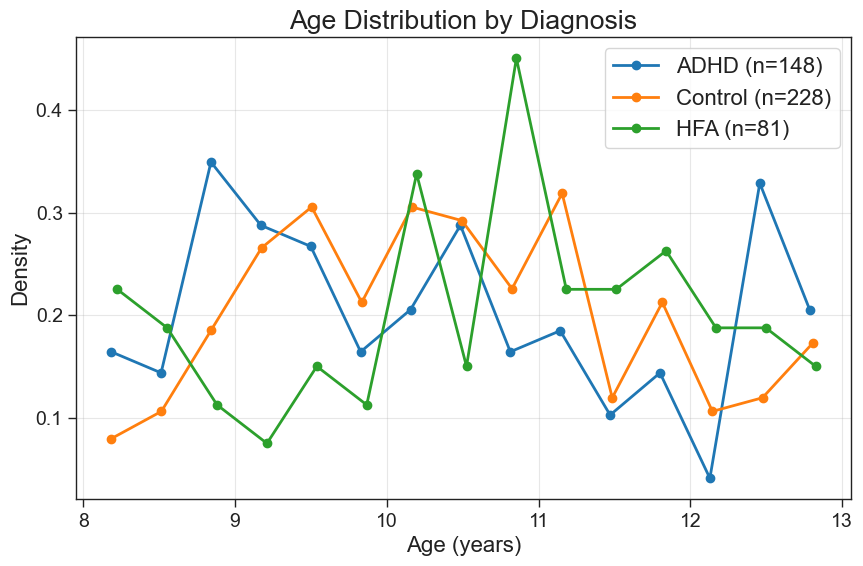

Age Statistics by Diagnosis:
ADHD: Mean=10.34, Std=1.42, Min=8.02, Max=12.95
Control: Mean=10.45, Std=1.23, Min=8.02, Max=12.97
HFA: Mean=10.66, Std=1.35, Min=8.06, Max=12.99


In [224]:
plt.figure(figsize=(10, 6))

# Create age distribution plot for each diagnosis using lines
for dx, df in dx_dataframes.items():
    # Create histogram data
    counts, bins = np.histogram(df['Age'], bins=15, density=True)



    # Calculate bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2
    # Plot as line
    plt.plot(bin_centers, counts, marker='o', linewidth=2, label=f'{dx} (n={len(df)})')

plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Age Distribution by Diagnosis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print summary statistics
print("Age Statistics by Diagnosis:")
for dx, df in dx_dataframes.items():
    print(f"{dx}: Mean={df['Age'].mean():.2f}, Std={df['Age'].std():.2f}, Min={df['Age'].min():.2f}, Max={df['Age'].max():.2f}")

## Age by diagnosis

In [225]:
# Create age counts by diagnosis
age_counts_by_dx = {}
for dx, df in dx_dataframes.items():
    rounded_ages = [round(age) for age in df['Age']]
    age_counts = pd.Series(rounded_ages).value_counts().sort_index()
    age_counts_by_dx[dx] = age_counts

# df with all ages and diagnoses
rounded_ages = np.array([round(age) for age in combined['Age']])
all_ages = sorted(np.unique(rounded_ages))
age_dx_df = pd.DataFrame(index=all_ages)
for dx in dx_dataframes.keys():
    age_dx_df[dx] = 0
    for age in all_ages:
        if age in age_counts_by_dx[dx]:
            age_dx_df.loc[age, dx] = age_counts_by_dx[dx][age]

# Save to CSV
age_dx_df.to_csv('age_diagnosis_counts.csv')
print(f"CSV saved with {len(age_dx_df)} age groups and {len(dx_dataframes)} diagnoses")

CSV saved with 6 age groups and 3 diagnoses


# Create Matrices

## Create Functions

In [226]:
def get_adjacency_matrix(timeseries_data, fisherZ=False, verbose = False):
    """ 
    Given timeseries data (ROIs x Timepoints), compute the adjacency matrix using Pearson correlation.
    Parameters:
    - timeseries_data: 2D array-like, shape (n_ROIs, n_timepoints)
        Time series data for each ROI.
    - fisherZ: bool, optional
        If True, apply Fisher Z-transformation to the correlation coefficients.
    Returns:
    - adj_matrix: 2D numpy array, shape (n_ROIs, n_ROIs)
        The computed adjacency matrix.
    """
    arr = np.asarray(timeseries_data)
    # Z-score each ROI across time ?
    # ave_timeseries = timeseries_data.mean(axis=1)
    # zscored_timeseries = (timeseries_data - ave_timeseries) / timeseries_data.std(axis=0)
    # correlation_matrix = zscored_timeseries.T @ zscored_timeseries
    # adj_matrix = np.corrcoef(zscored_timeseries, rowvar=False)
    # t_arr = arr.T
    adj_matrix = np.corrcoef(arr, rowvar=True)
    np.fill_diagonal(adj_matrix, 0.0)  # Remove self-loops!
    if fisherZ:
        adj_matrix = np.arctanh(np.clip(adj_matrix, -0.9999, 0.9999))
    if verbose:        
        print(f"Input shape: {arr.shape}")
        print(f"Output shape: {adj_matrix.shape}")
    return adj_matrix

In [227]:
def find_nan_rows(matrix):
    """
    Find all rows in the adjacency matrix that contain NaN values.
    
    Parameters:
    matrix (numpy.ndarray): The adjacency matrix to check
    
    Returns:
    numpy.ndarray: Array of row indices that contain NaN values
    """
    nan_rows = np.where(np.isnan(matrix).any(axis=1))[0]
    return nan_rows


def find_zero_rows(matrix): #whole row
    """
    Find all rows in the adjacency matrix that are entirely zeros.
    
    Parameters:
    matrix (numpy.ndarray): The adjacency matrix to check
    
    Returns:
    numpy.ndarray: Array of row indices that are entirely zeros
    """
    zero_rows = np.where(np.all(matrix == 0, axis=1))[0]
    return zero_rows

In [228]:
import os
import pickle


def remove_nodes_from_all_networks(nodes):
    nodes = sorted(set(nodes), reverse=True)
    matrices = os.listdir('networkx_graphs/')
    for matrix in matrices:
        # for node in nodes:
        #     # Adjust for previously removed nodes
        #     rel_zeros = tracked_nodes[:node].count(0)
        #     node = node - rel_zeros
        #     # Remove node if still tracked
        #     if tracked_nodes[node]:
        #         tracked_nodes[node] = 0
        #         mat = np.load(f'/{matrix}')
        #         mat = np.delete(mat, node, axis=0)
        #         mat = np.delete(mat, node, axis=1)
        #         np.save(f'adj_matrices/{matrix}', mat)
        with open(f'networkx_graphs/{matrix}', 'rb') as f:
            graph = pickle.load(f)
        for node in nodes:
            if node in graph:
                graph.remove_node(node)
                tracked_nodes[node] = 0
        with open(f'networkx_graphs/{matrix}', 'wb') as f:
            pickle.dump(graph, f, pickle.HIGHEST_PROTOCOL)


## Apply Functions, Save files

In [229]:
import os
import pickle

def create_adj_matrices(files):
    global tracked_nodes
    nan = {}
    sparse = {}
    tracked_nodes = [1] * 200
    if not os.path.exists('adj_matrices'):
        os.makedirs('adj_matrices')
    if not os.path.exists('networkx_graphs'):
        os.makedirs('networkx_graphs')
    for folder in files:
        subjects = os.listdir(folder)
        for subject in subjects:
            # Read raw timeseries data
            timeseries = pd.read_csv(f'{folder}/{subject}/timeseries_cc200.csv')
            
            # Find problematic rows
            nans = find_nan_rows(timeseries)
            spars = find_zero_rows(timeseries)
            if len(nans) > 0:
                nan[subject] = nans
            if len(spars) > 0:
                sparse[subject] = spars
                
            # Compute adjacency matrix
            matrix = get_adjacency_matrix(timeseries)
            
            # Save adjacency matrix
            np.save(f'adj_matrices/{subject}_am.npy', matrix)
            
            # Create networkx graph and save
            graph = nx.from_numpy_array(matrix)
            with open(f'networkx_graphs/{subject}_graph.gpickle', 'wb') as f:
                pickle.dump(graph, f, pickle.HIGHEST_PROTOCOL)
            # print(f'Subject: {subject}, Adjacency Matrix Shape: {matrix.shape}')
    return nan, sparse
            

In [230]:
nan, sparse = create_adj_matrices(files)

KeyboardInterrupt: 

## Examine Problem rows

In [ ]:
# Display stats about NaN and sparse rows
print("NaN Statistics:")
if nan:
    nan_lengths = [len(indices) for indices in nan.values()]
    nan_df = pd.DataFrame(nan_lengths, columns=['NaN Row Count'], index=nan.keys())
    # unique_lengths, counts = np.unique(nan_lengths, return_counts=True)
    # Sort by count (descending) and get top 4
    # sorted_indices = np.argsort(counts)[::-1]
    nan_df = nan_df.sort_values(by='NaN Row Count', ascending=False)
    top_4_nan = nan_df.head(4)
    print(f"Top 4 most common NaN row counts:")
    for index, row in top_4_nan.iterrows():
        print(f"  {row['NaN Row Count']} NaN rows: {index} subjects")
    print(f"Total subjects with NaN rows: {len(nan)}")
else:
    print("No subjects with NaN rows found")

print("\nSparse Statistics:")
if sparse:
    sparse_lengths = [len(indices) for indices in sparse.values()]
    sparse_df = pd.DataFrame(sparse_lengths, columns=['Sparse Row Count'], index=sparse.keys())
    # unique_lengths, counts = np.unique(sparse_lengths, return_counts=True)
    # Sort by count (descending) and get top 4
    # sorted_indices = np.argsort(counts)[::-1]
    # top_4_sparse = [(unique_lengths[i], counts[i]) for i in sorted_indices[:4]]
    sparse_df = sparse_df.sort_values(by='Sparse Row Count', ascending=False)
    top_4_sparse = sparse_df.head(4)
    print(f"Top 4 most common zero row counts:")
    for index, row in top_4_sparse.iterrows():
        print(f"  {row['Sparse Row Count']} zero rows: {index} subjects")
    print(f"Total subjects with zero rows: {len(sparse)}")
else:
    print("No subjects with zero rows found")

NaN Statistics:
No subjects with NaN rows found

Sparse Statistics:
Top 4 most common zero row counts:
  1 zero rows: sub-236 subjects
Total subjects with zero rows: 1


In [ ]:
print(f"Subject {list(sparse.keys())[0]} has zero row at node: {sparse[list(sparse.keys())[0]][0]}")

Subject sub-236 has zero row at node: 185


In [ ]:
# deal with nodes with no info
# remove_nodes([sparse[list(sparse.keys())[0]][0]])
remove_nodes_from_all_networks([sparse[list(sparse.keys())[0]][0]])

Investigate NaNs and zeroes across a whole column/row. Need to remove these...

Mindful. Need to balance
1. One person missing a lot (30%) of their network? Lose that subject.
2. If parcellation x is bad/missing in say, 5% of the population, you want to remove that region from everyone so htat your regions are all the same size.

When balancing these, subjects matter more than regions. Try to save as many subjects as possible.

Connectome will have self-loops. Remove self-loops!

In [ ]:
analysisdf = pd.DataFrame(combined['Subj'].copy(), columns=['Subj'])

In [ ]:
analysisdf

,Subj
0,sub-004
1,sub-006
2,sub-007
3,sub-008
4,sub-010
...,...
452,sub-482
453,sub-491
454,sub-494
455,sub-506


# Thresholding

## Thresholding min where everyone is connected

In [ ]:
# def min_threshold(graph: nx.Graph, test_range = range(30,10,-1)):
#     best_thresh = None
#     best_graph = None
#     n_edges = graph.number_of_edges()
#     n_nodes = graph.number_of_nodes()
#     max_possible_edges = n_nodes * (n_nodes - 1) / 2
#     # current_density = n_edges / max_possible_edges
#     # print(f"Testing range: {test_range}")
#     i=0
#     while best_thresh is None and i < len(test_range):
#         thresh = test_range[i]
#         # print(f"i={i}, Testing threshold: {thresh}")
#         density = thresh / 100.0
#         target = int(density * max_possible_edges)
#         # print(f"Target density: {density}")
#         # print(f"Target edges: {target}")
#         # Take absolute value of edge weights for proper thresholding
#         edges_with_abs_weights = []
#         for u, v, data in graph.edges(data=True):
#             abs_weight = abs(data['weight'])
#             edges_with_abs_weights.append((u, v, {'weight': abs_weight}))
#         # Create new graph with absolute weight values
#         abs_graph = nx.Graph()
#         abs_graph.add_nodes_from(graph.nodes(data=True))
#         abs_graph.add_edges_from(edges_with_abs_weights)
#         # Sort edges by weight
#         edges = sorted(abs_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
#         # Sort edges by weight
#         edges = sorted(graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
        
#         # Create new graph with top edges
#         threshed_g = nx.Graph()
#         threshed_g.add_nodes_from(graph.nodes(data=True))
        
#         # edges_to_add = min(target, n_edges)
#         threshed_g.add_edges_from(edges[:target]) # Automatically handles case where target > n_edges ?
        
#         # new_n_edges = threshed_g.number_of_edges()
        
#         if nx.is_connected(threshed_g):
#             best_graph = threshed_g
#         else:
#             # If not connected, keep previous threshold
#             if i >0:
#                 best_thresh = test_range[i-1] 
#             else: 
#                 print(f"Graph is not connected at the highest threshold.")
#                 return -1
#             # print(f"Graph at threshold {thresh} is not connected ({new_n_edges} edges).")
#             print(f"Best connected graph at threshold {best_thresh} with {best_graph.number_of_edges()} edges. ")
#         i += 1

#     return best_thresh #, best_graph

In [ ]:
def min_threshold(graph: nx.Graph, test_range = range(30,10,-1)):
    ''' 
    Determine the minimum threshold percentage at which the graph remains connected.
    Parameters:
    - graph: networkx.Graph
        The input graph with weighted edges.
    - test_range: iterable of int, optional
        The range of threshold percentages to test (default: range(30,10,-1)).
    Returns:
    - best_thresh: int
        The highest threshold percentage at which the graph remains connected.
    '''
    best_thresh = -1
    best_graph = None
    # n_edges = graph.number_of_edges()
    n_nodes = graph.number_of_nodes()
    max_possible_edges = n_nodes * (n_nodes - 1) / 2
    
    for i, thresh in enumerate(test_range):
        density = thresh / 100.0
        target = int(density * max_possible_edges)
        
        # Take absolute value of edge weights for proper thresholding
        edges_with_abs_weights = []
        for u, v, data in graph.edges(data=True):
            abs_weight = abs(data['weight'])
            edges_with_abs_weights.append((u, v, {'weight': abs_weight}))
        
        # Create new graph with absolute weight values
        abs_graph = nx.Graph()
        abs_graph.add_nodes_from(graph.nodes(data=True))
        abs_graph.add_edges_from(edges_with_abs_weights)
        
        # Sort edges by absolute weight
        edges = sorted(abs_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
        
        # Create new graph with top edges
        threshed_g = nx.Graph()
        threshed_g.add_nodes_from(graph.nodes(data=True))
        threshed_g.add_edges_from(edges[:target])
        
        if nx.is_connected(threshed_g):
            # Still connected, update best and continue
            best_thresh = thresh
            best_graph = threshed_g
        else:
            # Just became disconnected, return previous threshold
            if best_thresh is not None:
                # print(f"Best connected graph at threshold {best_thresh}% with {best_graph.number_of_edges()} edges.")
                return best_thresh
            else:
                # print(f"Graph is not connected even at the highest threshold ({test_range[0]}%).")
                return -1
    

Find the minimum threshold for every subject, then determine the highest across all.

### Get all thresholds

In [ ]:
cutoff = 10 # the max number to test in the first iteration of threshold finding
thresholds = {}

In [ ]:
for i, subject in enumerate(analysisdf['Subj']):
    if thresholds.get(subject) is not None and thresholds.get(subject) != -1: # already have a valid threshold, lets me rerun cell.
        continue
    print(f"Processing subject {i+1}/{len(analysisdf)}: {subject}")
    # matrix = np.load(f'adj_matrices/{subject}_am.npy')
    with open(f'networkx_graphs/{subject}_graph.gpickle', 'rb') as f:
        G = pickle.load(f)
    # matrix = nx.to_numpy_array(G)
    # Threshold the matrix
    # print(f"Processing subject {subject}, {matrix.shape}")
    s_cutoff = cutoff
    threshold = min_threshold(G, range(s_cutoff,0,-1))
    while threshold == -1 and s_cutoff < 100:
        s_cutoff += 10
        threshold = min_threshold(G, range(s_cutoff,0,-1))
        
    if threshold == None:
        print(f"Subject {subject} returned None instead of -1")
    else:
        print(f"Subject {subject} minimum connected threshold: {threshold}%")
    # thresholded_graphs[subject] = (threshold, G)
    thresholds[subject] = threshold


Processing subject 38/457: sub-063
Subject sub-063 minimum connected threshold: 57%
Processing subject 49/457: sub-103
Subject sub-103 minimum connected threshold: 74%
Processing subject 75/457: sub-153
Subject sub-153 minimum connected threshold: 71%
Processing subject 106/457: sub-221
Subject sub-221 minimum connected threshold: 60%
Processing subject 118/457: sub-237
Subject sub-237 minimum connected threshold: 64%
Processing subject 161/457: sub-321
Subject sub-321 minimum connected threshold: 58%
Processing subject 165/457: sub-343
Subject sub-343 minimum connected threshold: 62%
Processing subject 169/457: sub-362
Subject sub-362 minimum connected threshold: 52%
Processing subject 205/457: sub-493
Subject sub-493 minimum connected threshold: 69%
Processing subject 215/457: sub-508
Subject sub-508 minimum connected threshold: 59%
Processing subject 243/457: sub-123
Subject sub-123 minimum connected threshold: 68%
Processing subject 246/457: sub-129
Subject sub-129 minimum connecte

In [ ]:
threshold_df = pd.DataFrame(list(thresholds.items()), columns = ['Subj','Thresh'])
threshold_df = threshold_df.sort_values(by='Thresh', ascending = False, ignore_index=True)
threshold_df

,Subj,Thresh
0,sub-411,75
1,sub-103,74
2,sub-334,72
3,sub-153,71
4,sub-493,69
...,...,...
452,sub-257,6
453,sub-193,6
454,sub-273,6
455,sub-137,6


In [ ]:
# The highest threshold across all subjects
threshold = threshold_df.iloc[0]['Thresh']
print(f"Maximum minimum connected threshold across all subjects: {threshold}%")

np.int64(75)

## Investigate High Thresholds
Get all the thresholds over max

In [ ]:
# prev_max = cutoff
max_thresh = 30 # the max number that is acceptable across all subjects
# rem_thresh = [(subject, threshold) for subject, threshold in thresholds.items() if threshold == -1 or threshold > max_thresh]
# subjects_over_cutoff = [subject for subject, threshold in rem_thresh]
# while rem_thresh:    
#     # Re-test failed thresholds
#     for subject, _ in rem_thresh[:]:  # copy of rem_thresh
#         matrix = np.load(f'adj_matrices/{subject}_am.npy')
#         # Find their thresholds
#         new_threshold = min_threshold(nx.from_numpy_array(matrix), range(prev_max+10, prev_max, -1))
#         if new_threshold != -1:
#             thresholds[subject] = new_threshold
#             rem_thresh.remove((subject, -1))
    
#     print(f"Tested up to {prev_max+ 10}%, remaining disconnected subjects: {len(rem_thresh)}")
    
#     prev_max += 10
#     if prev_max > 100:
#         print(f"Warning: Cannot find connected graphs for {len(rem_thresh)} subjects")
#         break

### Get Disconnected Components

In [ ]:
def get_disconnected_comp(density, subjects):
    ''' 
    Examines every subject in the subject list and returns the components that are disconnected from the main network at the given density.
    Parameters:
    - density: float
        The density threshold (as a percentage, e.g., 50 for 50%)
    - subjects: list of str
        List of subject identifiers to analyze.
    Returns:
    - subject_disc_nodes: dict
    
    '''
    subject_disc_nodes = {}
    density = density / 100.0
    for subject in subjects:
        best_thresh = None
        best_graph = None
        # graph = nx.from_numpy_array(np.load(f'adj_matrices/{subject}_am.npy'))
        with open(f'networkx_graphs/{subject}_graph.gpickle', 'rb') as f:
            graph = pickle.load(f)
        n_edges = graph.number_of_edges()
        n_nodes = graph.number_of_nodes()
        max_possible_edges = n_nodes * (n_nodes - 1) / 2
            
        target = int(density * max_possible_edges)
        
        # Take absolute value of edge weights for proper thresholding
        edges_with_abs_weights = []
        for u, v, data in graph.edges(data=True):
            abs_weight = abs(data['weight'])
            edges_with_abs_weights.append((u, v, {'weight': abs_weight}))
        
        # Create new graph with absolute weight values
        abs_graph = nx.Graph()
        abs_graph.add_nodes_from(graph.nodes(data=True))
        abs_graph.add_edges_from(edges_with_abs_weights)
        
        # Sort edges by absolute weight
        edges = sorted(abs_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
        
        # Create new graph with top edges
        threshed_g = nx.Graph()
        threshed_g.add_nodes_from(graph.nodes(data=True))
        threshed_g.add_edges_from(edges[:target])
        if nx.is_connected(threshed_g):
            print(f"Subject {subject} is connected at {density}% threshold.")
            continue

        # Find the disconnected nodes and smaller components
        components = list(nx.connected_components(threshed_g))
        sorted_comp = sorted(components, key=len, reverse=True)
        sorted_comp = sorted_comp[1:]  # Exclude largest component
        
        sorted_comp_sizes = [len(comp) for comp in sorted_comp]
        print(f"Subject {subject} at {density}% threshold:")
        print(f" Components: ")
        for i, comp in enumerate(sorted_comp):
            print(f"   Component {i+1}: {comp}")
        print(f"  Component sizes: {sorted_comp_sizes}")
        subject_disc_nodes[subject] = sorted_comp
    return subject_disc_nodes

In [ ]:
subjects_over_max = [subject for subject, threshold in thresholds.items() if threshold > max_thresh]
print(f"Subjects over max threshold ({max_thresh}%): {len(subjects_over_max)}")

In [ ]:
subject_disc_nodes = get_disconnected_comp(cutoff, subjects_over_max)
print(subject_disc_nodes)
# Make a flat set of all disconnected nodes across all subjects
all_disc_nodes = [node for components in subject_disc_nodes.values() # for every list of components
                  for component in components # for every component in the list
                  for node in component] # for every node in the component
print(all_disc_nodes)

Subject sub-015 at 0.1% threshold:
 Components: 
   Component 1: {35, 43, 46, 16, 92}
   Component 2: {192, 160, 197, 150, 188}
   Component 3: {49, 158, 13, 133}
   Component 4: {50, 84}
   Component 5: {2}
   Component 6: {31}
   Component 7: {66}
   Component 8: {82}
   Component 9: {107}
   Component 10: {108}
   Component 11: {110}
   Component 12: {128}
   Component 13: {174}
  Component sizes: [5, 5, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Subject sub-017 at 0.1% threshold:
 Components: 
   Component 1: {138, 76, 143, 25, 60}
   Component 2: {35, 84}
   Component 3: {51, 69}
   Component 4: {16}
   Component 5: {28}
   Component 6: {30}
   Component 7: {41}
   Component 8: {42}
   Component 9: {43}
   Component 10: {45}
   Component 11: {47}
   Component 12: {50}
   Component 13: {57}
   Component 14: {65}
   Component 15: {66}
   Component 16: {70}
   Component 17: {82}
   Component 18: {85}
   Component 19: {92}
   Component 20: {99}
   Component 21: {108}
   Component 22: {128}
   C

In [ ]:
from collections import Counter

n_nodes = Counter(all_disc_nodes)
n_nodes

Counter({128: 74,
         66: 69,
         192: 45,
         196: 45,
         146: 43,
         158: 40,
         25: 40,
         50: 39,
         85: 35,
         133: 34,
         108: 34,
         28: 33,
         84: 30,
         90: 29,
         197: 27,
         153: 27,
         188: 26,
         35: 25,
         122: 25,
         13: 23,
         143: 23,
         45: 23,
         167: 23,
         110: 21,
         76: 21,
         41: 21,
         46: 20,
         40: 20,
         111: 18,
         179: 18,
         160: 17,
         69: 16,
         176: 16,
         55: 16,
         120: 16,
         82: 14,
         92: 13,
         49: 13,
         60: 13,
         30: 13,
         65: 12,
         127: 12,
         43: 11,
         16: 11,
         10: 10,
         99: 9,
         181: 9,
         174: 8,
         42: 8,
         72: 8,
         107: 7,
         57: 7,
         150: 6,
         18: 6,
         56: 6,
         142: 6,
         2: 5,
         47: 5,
   

In [ ]:
import itertools
# Create a frame that records the number of nodes removed, which nodes are removed, and which subjects become connected
disc_node_set = set(all_disc_nodes)
frame = []
broken_subject_graphs = {}

for subject in subjects_over_max:
    # matr = np.load(f'adj_matrices/{subject}_am.npy')
    # graph = nx.from_numpy_array(matr)
    with open(f'networkx_graphs/{subject}_graph.gpickle', 'rb') as f:
        graph = pickle.load(f)
    broken_subject_graphs[subject] = graph
    
for n_nodes_removed in range(6,20):
    for comb in itertools.combinations(disc_node_set, n_nodes_removed):
        # Track which subjects become connected with this combination
        subjects_fixed = []
                
        for subject, graph in broken_subject_graphs.items():
            # Create a copy of the graph
            g_copy = graph.copy()
            
            # Remove the nodes listed in comb
            for node in sorted(comb, reverse=True):
                if node in g_copy:
                    g_copy.remove_node(node)
                         
            if nx.is_connected(g_copy):
                subjects_fixed.append(subject)
                
        if subjects_fixed:
            frame.append({
                'n_nodes_removed': n_nodes_removed,
                'nodes_removed': comb,
                'subjects_fixed': subjects_fixed,
                'n_subjects_fixed': len(subjects_fixed)
            })
            print(f"Removed nodes {comb}, fixed {len(subjects_fixed)} subjects: {subjects_fixed}")

                
frame_df = pd.DataFrame(frame)

Removed nodes (0, 2, 4, 5, 9, 10), fixed 90 subjects: ['sub-015', 'sub-017', 'sub-023', 'sub-029', 'sub-031', 'sub-037', 'sub-042', 'sub-050', 'sub-063', 'sub-103', 'sub-105', 'sub-151', 'sub-153', 'sub-179', 'sub-186', 'sub-210', 'sub-211', 'sub-217', 'sub-218', 'sub-221', 'sub-228', 'sub-237', 'sub-258', 'sub-276', 'sub-288', 'sub-292', 'sub-294', 'sub-301', 'sub-321', 'sub-343', 'sub-362', 'sub-389', 'sub-415', 'sub-436', 'sub-458', 'sub-462', 'sub-467', 'sub-488', 'sub-493', 'sub-508', 'sub-094', 'sub-121', 'sub-123', 'sub-129', 'sub-135', 'sub-149', 'sub-160', 'sub-164', 'sub-180', 'sub-194', 'sub-197', 'sub-200', 'sub-280', 'sub-300', 'sub-306', 'sub-311', 'sub-313', 'sub-314', 'sub-315', 'sub-334', 'sub-338', 'sub-341', 'sub-344', 'sub-345', 'sub-350', 'sub-358', 'sub-360', 'sub-363', 'sub-369', 'sub-372', 'sub-379', 'sub-382', 'sub-399', 'sub-407', 'sub-411', 'sub-459', 'sub-463', 'sub-464', 'sub-468', 'sub-479', 'sub-504', 'sub-513', 'sub-514', 'sub-233', 'sub-279', 'sub-316',

Nodes to 

In [ ]:
# excluded_nodes =[node for node, count in n_nodes.items() if count > 2]
# excluded_nodes = sorted(excluded_nodes, reverse=True) # put in descending order for easier removal from the matrix
# remove_nodes(excluded_nodes)

In [ ]:
# Find subjects requiring >50% edges
high_thresh_subjects = threshold_df[threshold_df['Thresh'] > 50]['Subj'].values

for subject in high_thresh_subjects:  # Check first 3
    # Load original timeseries
    folder = 'test'  # or training/validation
    if subject in os.listdir('training'):
        folder = 'training'
    elif subject in os.listdir('validation'):
        folder = 'validation'
    timeseries = pd.read_csv(f'{folder}/{subject}/timeseries_cc200.csv')
    
    print(f"\nSubject: {subject}")
    print(f"Timeseries shape: {timeseries.shape}")
    print(f"NaN count: {timeseries.isna().sum().sum()}")
    print(f"Zero rows: {(timeseries == 0).all(axis=1).sum()}")
    
    # Check correlation distribution
    matrix = np.load(f'adj_matrices/{subject}_am.npy')
    print(f"Correlation range: [{matrix.min():.3f}, {matrix.max():.3f}]")
    print(f"Mean correlation: {matrix.mean():.3f}")


Subject: sub-411
Timeseries shape: (199, 137)
NaN count: 0
Zero rows: 0
Correlation range: [-0.402, 0.975]
Mean correlation: 0.535

Subject: sub-103
Timeseries shape: (199, 156)
NaN count: 0
Zero rows: 0
Correlation range: [-0.625, 0.968]
Mean correlation: 0.527

Subject: sub-334
Timeseries shape: (199, 137)
NaN count: 0
Zero rows: 0
Correlation range: [-0.507, 0.959]
Mean correlation: 0.504

Subject: sub-153
Timeseries shape: (199, 156)
NaN count: 0
Zero rows: 0
Correlation range: [-0.333, 0.951]
Mean correlation: 0.457

Subject: sub-493
Timeseries shape: (199, 156)
NaN count: 0
Zero rows: 0
Correlation range: [-0.389, 0.951]
Mean correlation: 0.522

Subject: sub-123
Timeseries shape: (199, 156)
NaN count: 0
Zero rows: 0
Correlation range: [-0.497, 0.947]
Mean correlation: 0.438

Subject: sub-316
Timeseries shape: (199, 156)
NaN count: 0
Zero rows: 0
Correlation range: [-0.616, 0.957]
Mean correlation: 0.466

Subject: sub-237
Timeseries shape: (199, 156)
NaN count: 0
Zero rows: 0
Cor

In [ ]:
# The highest threshold across all subjects
threshold = threshold_df.iloc[0]['Thresh']
threshold

np.int64(75)

In [ ]:
def topx_threshold(graph: nx.Graph, thresh: 0.1):
    '''
    Threshold the graph to keep only the top x% of edges by weight.
    Returns the thresholded graph.
    '''
    # Calculate number of edges to keep
    n_edges = graph.number_of_edges()
    n_nodes = graph.number_of_nodes()
    max_possible_edges = n_nodes * (n_nodes - 1) / 2
    target = int(thresh * max_possible_edges)
    # Take absolute value of edge weights for proper thresholding
    edges_with_abs_weights = []
    for u, v, data in graph.edges(data=True):
        abs_weight = abs(data['weight'])
        edges_with_abs_weights.append((u, v, {'weight': abs_weight}))
    # Create new graph with absolute weight values
    abs_graph = nx.Graph()
    abs_graph.add_nodes_from(graph.nodes(data=True))
    abs_graph.add_edges_from(edges_with_abs_weights)
    # Sort edges by weight
    edges = sorted(abs_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
    # Create new graph with all nodes and top edges
    threshed_g = nx.Graph()
    threshed_g.add_nodes_from(graph.nodes(data=True))
    threshed_g.add_edges_from(edges[:target])
    return threshed_g

Matrix shape: (199, 199)
Matrix range: [-0.5071, 0.9589]
Mean correlation: 0.5038
Std correlation: 0.2104

Nodes: 199
Total edges: 19701
Max possible edges: 19701.0
Current density: 100.00%

=== Connectivity Test ===
Threshold 10%: 1970 edges, Connected: False, Components: 20
Threshold 20%: 3940 edges, Connected: False, Components: 9
Threshold 30%: 5910 edges, Connected: False, Components: 9
Threshold 50%: 9850 edges, Connected: False, Components: 4
Threshold 70%: 13790 edges, Connected: False, Components: 2
Threshold 85%: 16745 edges, Connected: True, Components: 1
Threshold 89%: 17533 edges, Connected: True, Components: 1
Threshold 90%: 17730 edges, Connected: True, Components: 1


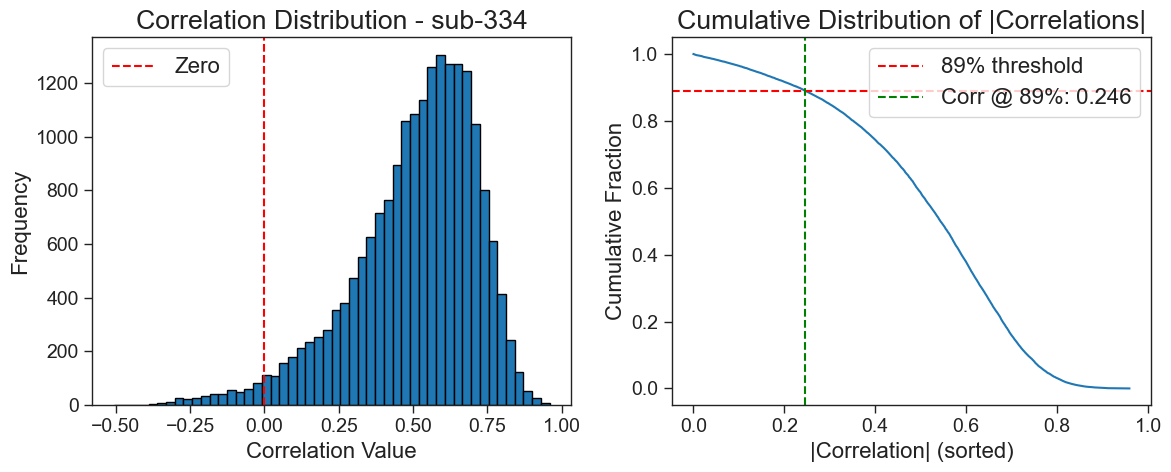


=== Node Analysis ===
Min node strength: 25.2477
Max node strength: 128.7723
Mean node strength: 101.5287

Nodes with strength < (mean - 2*std): 14
Weak node indices: [ 40  46  50  66  84 108 111 122 128 133 160 167 192 197]
Their strengths: [25.81547588 53.33036176 40.23674066 29.16365262 34.3018775  34.35000745
 57.22009557 33.17511431 39.7043758  55.9758342  55.45616708 52.67406949
 25.24774797 41.3820921 ]


In [ ]:
# Load subject 334's matrix
subject = 'sub-334'
matrix = np.load(f'adj_matrices/{subject}_am.npy')

print(f"Matrix shape: {matrix.shape}")
print(f"Matrix range: [{matrix.min():.4f}, {matrix.max():.4f}]")
print(f"Mean correlation: {matrix.mean():.4f}")
print(f"Std correlation: {matrix.std():.4f}")

# Create full graph
G_full = nx.from_numpy_array(matrix)
n_nodes = G_full.number_of_nodes()
n_edges = G_full.number_of_edges()
max_possible_edges = n_nodes * (n_nodes - 1) / 2

print(f"\nNodes: {n_nodes}")
print(f"Total edges: {n_edges}")
print(f"Max possible edges: {max_possible_edges}")
print(f"Current density: {n_edges / max_possible_edges:.2%}")

# Check if fully connected at different thresholds
test_thresholds = [0.10, 0.20, 0.30, 0.50, 0.70, 0.85, 0.89, 0.90]

print("\n=== Connectivity Test ===")
for thresh in test_thresholds:
    G_thresh = topx_threshold(G_full, thresh)
    n_components = nx.number_connected_components(G_thresh)
    is_connected = nx.is_connected(G_thresh)
    
    print(f"Threshold {thresh:.0%}: {G_thresh.number_of_edges()} edges, "
          f"Connected: {is_connected}, Components: {n_components}")

# Visualize correlation distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Get upper triangle (excluding diagonal)
upper_triangle = matrix[np.triu_indices_from(matrix, k=1)]
plt.hist(upper_triangle, bins=50, edgecolor='black')
plt.xlabel('Correlation Value')
plt.ylabel('Frequency')
plt.title(f'Correlation Distribution - {subject}')
plt.axvline(x=0, color='r', linestyle='--', label='Zero')
plt.legend()

plt.subplot(1, 2, 2)
# Cumulative distribution
sorted_corr = np.sort(np.abs(upper_triangle))[::-1]
cumulative = np.arange(1, len(sorted_corr) + 1) / len(sorted_corr)
plt.plot(sorted_corr, cumulative)
plt.xlabel('|Correlation| (sorted)')
plt.ylabel('Cumulative Fraction')
plt.title('Cumulative Distribution of |Correlations|')
plt.axhline(y=0.89, color='r', linestyle='--', label='89% threshold')
plt.axvline(x=sorted_corr[int(0.89 * len(sorted_corr))], color='g', 
            linestyle='--', label=f'Corr @ 89%: {sorted_corr[int(0.89 * len(sorted_corr))]:.3f}')
plt.legend()

plt.tight_layout()
plt.show()

# Check for problematic nodes
print("\n=== Node Analysis ===")
node_strengths = np.sum(np.abs(matrix), axis=1)
print(f"Min node strength: {node_strengths.min():.4f}")
print(f"Max node strength: {node_strengths.max():.4f}")
print(f"Mean node strength: {node_strengths.mean():.4f}")

# Find weak nodes
weak_threshold = node_strengths.mean() - 2 * node_strengths.std()
weak_nodes = np.where(node_strengths < weak_threshold)[0]
print(f"\nNodes with strength < (mean - 2*std): {len(weak_nodes)}")
if len(weak_nodes) > 0:
    print(f"Weak node indices: {weak_nodes}")
    print(f"Their strengths: {node_strengths[weak_nodes]}")

In [ ]:
thresholded_graphs = {}
plt.figure(figsize=(10, 6))
for subject in analysisdf['Subj']:
    matrix = np.load(f'adj_matrices/{subject}_am.npy')
    # Threshold the matrix
    # print(f"Processing subject {subject}")
    G = topx_threshold(nx.from_numpy_array(matrix), threshold)
    thresholded_graphs[subject] = G
    if not nx.is_connected(G):
        print(f"Subject {subject} is not connected.")
        break

<Figure size 1000x600 with 0 Axes>

Subject sub-004: Degrees: [172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172]
Subject sub-006: Degrees: [177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 1

c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site

Subject sub-099: Degrees: [198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198

c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site

Subject sub-210: Degrees: [198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198

c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site

Subject sub-298: Degrees: [198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198

c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site

Subject sub-488: Degrees: [198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198

c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site

Subject sub-155: Degrees: [198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198

c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site

Subject sub-313: Degrees: [198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198

c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site

Subject sub-390: Degrees: [198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198

c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site

Subject sub-485: Degrees: [198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198

c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site

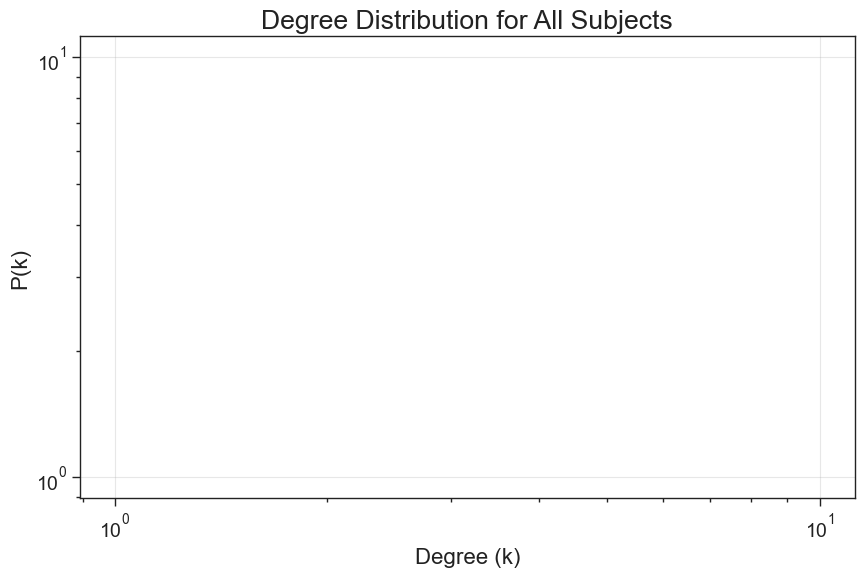

In [ ]:
plt.figure(figsize=(10, 6))
for subject, G in thresholded_graphs.items():
    degrees = [d for n, d in G.degree()]
    print(f"Subject {subject}: Degrees: {degrees}")
    avg_degree = np.mean(degrees)
    analysisdf.loc[analysisdf['Subj'] == subject, 'Average Degree'] = avg_degree
    kmin = np.min(degrees)
    analysisdf.loc[analysisdf['Subj'] == subject, 'Min Degree'] = kmin
    kmax = np.max(degrees)
    analysisdf.loc[analysisdf['Subj'] == subject, 'Max Degree'] = kmax
    
    bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=10)
    density, _ = np.histogram(degrees, bins=bin_edges, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.loglog(bin_centers, density, alpha=0.3, linewidth=0.5)

plt.xlabel('Degree (k)')
plt.ylabel('P(k)')
plt.title('Degree Distribution for All Subjects')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
analysisdf

,Subj,Average Degree,Min Degree,Max Degree
0,sub-004,172.0,172.0,172.0
1,sub-006,177.0,177.0,177.0
2,sub-007,176.0,176.0,176.0
3,sub-008,186.0,186.0,186.0
4,sub-010,189.0,189.0,189.0
...,...,...,...,...
452,sub-482,198.0,198.0,198.0
453,sub-491,198.0,198.0,198.0
454,sub-494,198.0,198.0,198.0
455,sub-506,198.0,198.0,198.0


# Get Representatives for each diagnosis

In [ ]:
# Pick a random subject from each diagnosis and plot their degree distribution

# Representatives for each diagnosis
representatives = {}
for dx, df in dx_dataframes.items():
    random_subject = df.sample(n=1)['Subj'].values[0]
    representatives[dx] = random_subject

# Degree Distribution

In [ ]:
def log_degree_distribution_figure(subject, dx): 
    G = thresholded_graphs[subject][1]
    degrees = [d for n, d in G.degree()]
    kmin = np.min(degrees)
    kmax = np.max(degrees)
    
    bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=10)
    density, _ = np.histogram(degrees, bins=bin_edges, density=True)
    
    plt.Figure(figsize=(8, 6))
    
    # get midpoint of each bin
    log_be = np.log10(bin_edges)
    x = 10 ** ((log_be[:-1] + log_be[1:]) / 2)
    
    plt.loglog(x, density, marker='o', linestyle='none')
    plt.title(f'Log Degree Distribution for {subject} - {dx}')
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)
    # remove right and top boundaries because they're ugly
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.show()

In [ ]:
def lin_degree_distribution_figure(subject, dx): 
    G = thresholded_graphs[subject][1]
    degrees = [d for n, d in G.degree()]
    kmin = np.min(degrees)
    kmax = np.max(degrees)
    
    # Make the bins
    bin_edges = np.linspace(kmin, kmax, num=10)
    # histogram
    density, _ = np.histogram(degrees, bins=bin_edges, density=True)
    
    plt.Figure(figsize=(8, 6))
    
    # "x" should be midpoint (IN LOG SPACE) of each bin
    log_be = np.log10(bin_edges)
    x = 10**((log_be[1:] + log_be[:-1])/2)

    plt.plot(x, density, marker='o', linestyle='none')
    plt.title(f'Linear Degree Distribution for {subject} - {dx}')
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)

    # remove right and top boundaries because they're ugly
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.show()

## Representative DD Graphs

In [ ]:
for dx, subject in representatives.items():
    log_degree_distribution_figure(subject, dx)

AttributeError: 'AtlasView' object has no attribute 'degree'

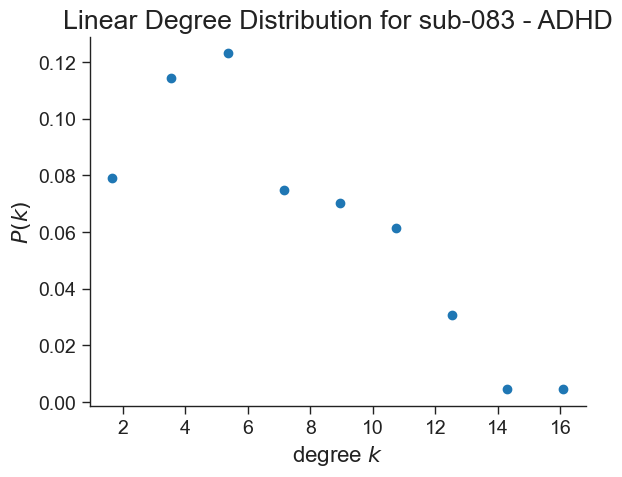

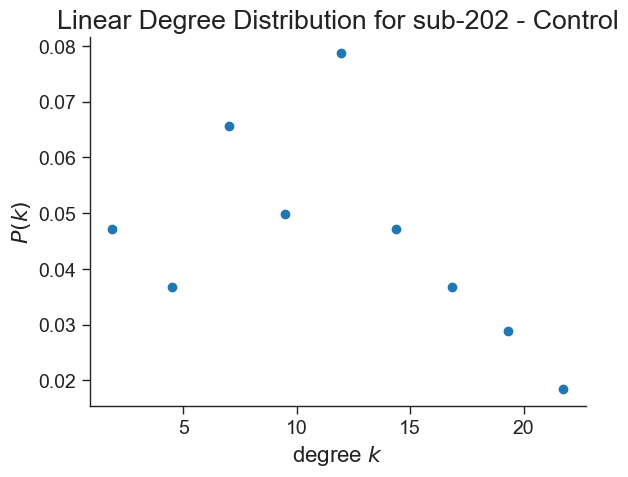

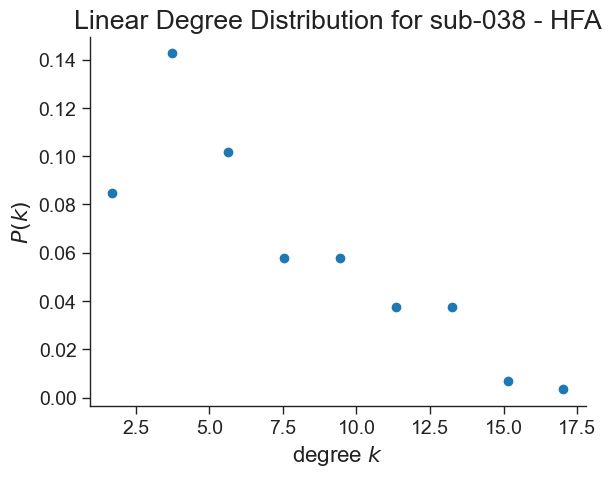

In [ ]:
for dx, subject in representatives.items():
    lin_degree_distribution_figure(subject, dx)

In [ ]:
print(dx_dataframes['ADHD'])


        Subj Sex    Age    DX  WISC_FSIQ  Edinburgh_Handedness
0    sub-066   F   9.52  ADHD      122.0                  0.67
1    sub-115   M  11.04  ADHD      112.0                  1.00
2    sub-128   F  12.31  ADHD       78.0                  0.81
3    sub-133   M   9.50  ADHD      102.0                  1.00
4    sub-309   M  12.31  ADHD       88.0                  1.00
..       ...  ..    ...   ...        ...                   ...
143  sub-427   M   8.93  ADHD      117.0                  1.00
144  sub-439   M   8.84  ADHD      105.0                  0.82
145  sub-470   F  11.73  ADHD       84.0                  1.00
146  sub-482   M   9.24  ADHD      115.0                  1.00
147  sub-491   M  11.98  ADHD      112.0                  1.00

[148 rows x 6 columns]


# Group Average Matrix

In [ ]:
def get_average_graph(thresholded_graphs):
    '''
    Compute the average adjacency matrix across all thresholded graphs.
    
    Parameters:
    - thresholded_graphs: dict
        Dictionary mapping subject IDs to their thresholded networkx graphs.
    
    Returns:
    - avg_matrix: numpy.ndarray
        The average adjacency matrix.
    '''
    n_subjects = len(thresholded_graphs)
    n_nodes = next(iter(thresholded_graphs.values())).number_of_nodes()
    sum_matrix = np.zeros((n_nodes, n_nodes))
    
    for subject, G in thresholded_graphs.items():
        adj_matrix = nx.to_numpy_array(G)
        sum_matrix += adj_matrix
    
    avg_matrix = sum_matrix / n_subjects
    return avg_matrix

In [ ]:
ave_matrices = {}
for dx, df in dx_dataframes.items():
    # Get subjects in this diagnosis
    subjects = df['Subj'].values
    matrices = []
    for subj in subjects:
        # Load their adjacency matrix
        matr = np.load(f"adj_matrices/{subj}_am.npy")
        # print(f"matrix before: {matr.shape}")
        matrix = topx_threshold(nx.from_numpy_array(matr), 0.13)
        matrix = nx.to_numpy_array(matrix)
        # print(f"Matrix shape: {matrix.shape}")
        matrices.append(matrix)
        
    np_matrices = np.array(matrices)
    ave_matrices[dx] = np.mean(np_matrices, axis=0)

matrix before: (128, 128)
Matrix shape: (128, 128)
matrix before: (156, 156)
Matrix shape: (156, 156)
matrix before: (156, 156)
Matrix shape: (156, 156)
matrix before: (156, 156)
Matrix shape: (156, 156)
matrix before: (123, 123)
Matrix shape: (123, 123)
matrix before: (156, 156)
Matrix shape: (156, 156)
matrix before: (156, 156)
Matrix shape: (156, 156)
matrix before: (156, 156)
Matrix shape: (156, 156)
matrix before: (156, 156)
Matrix shape: (156, 156)
matrix before: (156, 156)
Matrix shape: (156, 156)
matrix before: (156, 156)
Matrix shape: (156, 156)
matrix before: (156, 156)
Matrix shape: (156, 156)
matrix before: (156, 156)
Matrix shape: (156, 156)
matrix before: (156, 156)
Matrix shape: (156, 156)
matrix before: (156, 156)
Matrix shape: (156, 156)
matrix before: (156, 156)
Matrix shape: (156, 156)
matrix before: (156, 156)
Matrix shape: (156, 156)
matrix before: (156, 156)
Matrix shape: (156, 156)
matrix before: (151, 151)
Matrix shape: (151, 151)
matrix before: (156, 156)
Matri

KeyboardInterrupt: 

In [ ]:
print(ave_matrices['ADHD'])

[[ 0.          0.69767283 -0.32428124 ... -0.08475463  0.414296
   0.85273868]
 [ 0.69767283  0.          0.18943392 ...  0.16062075  0.09109772
   0.31707087]
 [-0.32428124  0.18943392  0.         ...  0.15144073 -0.05173356
  -0.30608835]
 ...
 [-0.08475463  0.16062075  0.15144073 ...  0.          0.53764561
  -0.06353734]
 [ 0.414296    0.09109772 -0.05173356 ...  0.53764561  0.
   0.71799498]
 [ 0.85273868  0.31707087 -0.30608835 ... -0.06353734  0.71799498
   0.        ]]


In [ ]:
for dx, mat in ave_matrices.items():
    log_degree_distribution_figure(mat, dx)
    lin_degree_distribution_figure(mat, dx)

KeyError: np.float64(-0.00610829497910294)

# Average CC

In [ ]:
ave_CCs = {}
for dx, G in group_matrices.items():
    w_cc = nx.clustering(G, weight='weight')
    ave_CCs[dx] = w_cc
    print(np.mean(list(w_cc.values())))

# Null Model